正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/03_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/02_Sadness_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/04_Fear_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/01_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/05_Disgust_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/01_Pleasure_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/06_Surprise_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/05_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/04_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/03_Anger_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/02_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/9/03_Quiet_features.csv
正在读取文件：/home/chester/data/emotio

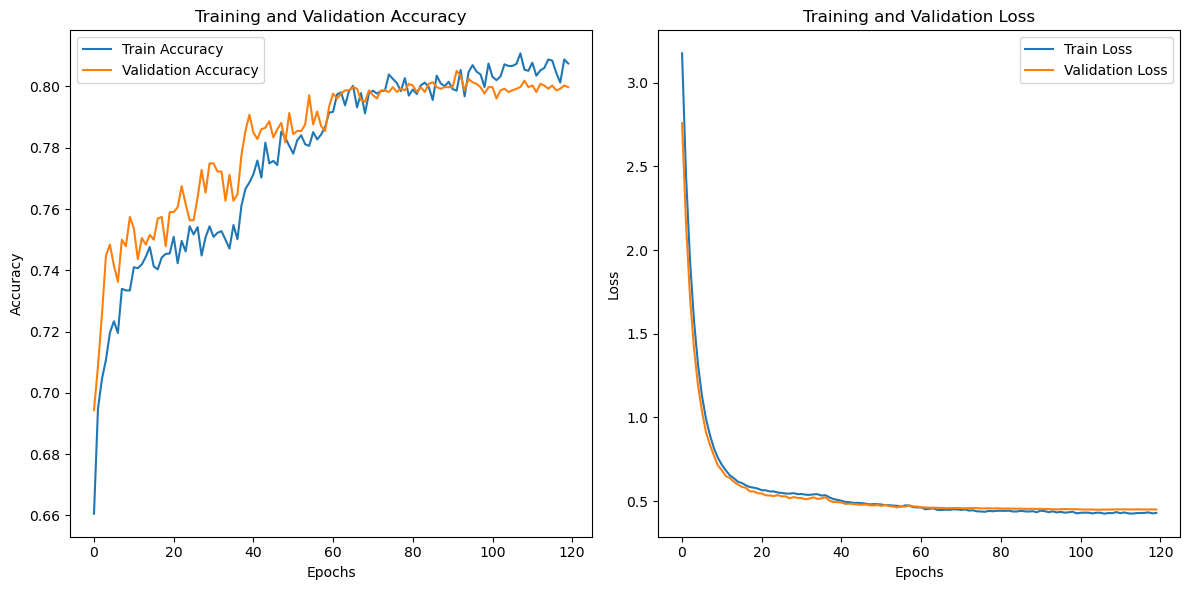

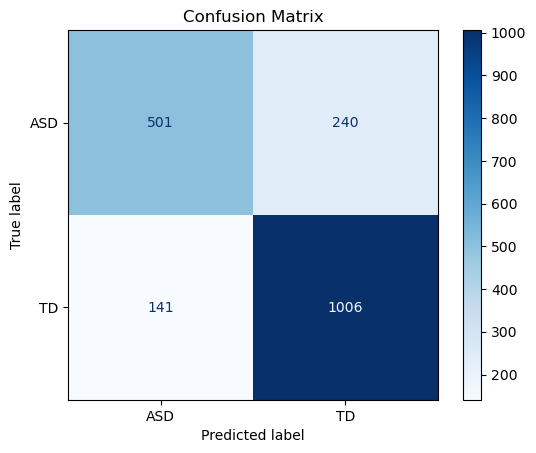

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 文件夹路径
asd_folder = r'/home/chester/data/emotion_dataset/features/asd' 
td_folder = r'/home/chester/data/emotion_dataset/features/td'    

# 加载ASD和TD数据并添加标签
def load_data_from_folder(folder_path, label):
    all_data = []
    # 遍历子文件夹
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):  # 如果是文件夹，继续遍历
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.csv'):  # 只处理CSV文件
                    file_path = os.path.join(subfolder_path, filename)
                    print(f"正在读取文件：{file_path}")
                    data = pd.read_csv(file_path)
                    data['label'] = label  # 添加标签列
                    all_data.append(data)
    # 合并所有数据
    return pd.concat(all_data, ignore_index=True)

# 读取ASD和TD数据
asd_data = load_data_from_folder(asd_folder, 'ASD')
td_data = load_data_from_folder(td_folder, 'TD')

# 合并数据
combined_data = pd.concat([asd_data, td_data], ignore_index=True)

# 从DataFrame中提取特征和标签（假设 'label' 为标签，其它为特征）
X = combined_data.drop(columns=['label'])
y = combined_data['label']

# 如果特征中包含非数值列，则使用独热编码转换
X = pd.get_dummies(X)

# 数据预处理
# 1. 标签编码（假设原始标签为字符串）
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 将类别转为0/1

# 2. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 3. 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型构建
model = Sequential()

# 输入层 + 第一个隐藏层
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 第二个隐藏层
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 第三个隐藏层
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

# 输出层
model.add(Dense(1, activation='sigmoid'))

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 添加回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
callbacks = [early_stopping, reduce_lr]

# 训练模型
history = model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    verbose=1,
    callbacks=callbacks
)

# 模型评估
# 预测
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # 转为1D数组

# 计算指标
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_rep)

# 可视化训练过程
plt.figure(figsize=(12, 6))

# 准确率曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 损失曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# ------------------------------
# 1. 加载数据并构造标签
# ------------------------------
def load_data_from_folder(folder_path, label):
    all_data = []
    label_encoder = LabelEncoder()  # 用于编码非数值型列
    # 遍历子文件夹
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):  # 如果是文件夹，继续遍历
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.csv'):  # 只处理CSV文件
                    file_path = os.path.join(subfolder_path, filename)
                    print(f"正在读取文件：{file_path}")
                    data = pd.read_csv(file_path)
                    
                    # 对非数值型列进行编码
                    non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
                    for col in non_numeric_columns:
                        data[col] = label_encoder.fit_transform(data[col].astype(str))
                    
                    # 添加标签列
                    data['label'] = label  
                    all_data.append(data)
    
    # 合并所有数据
    return pd.concat(all_data, ignore_index=True)

# 设置文件夹路径
asd_eeg_folder = r'/home/chester/data/emotion_dataset/features/asd'  
td_eeg_folder = r'/home/chester/data/emotion_dataset/features/td'    
asd_video_folder = r'/home/chester/data/video_feature/asd'  
td_video_folder = r'/home/chester/data/video_feature/td'   

# 读取数据
asd_eeg = load_data_from_folder(asd_eeg_folder, 'ASD')
td_eeg = load_data_from_folder(td_eeg_folder, 'TD')
asd_video = load_data_from_folder(asd_video_folder, 'ASD')
td_video = load_data_from_folder(td_video_folder, 'TD')

# 合并EEG和视频数据
eeg_data = pd.concat([asd_eeg, td_eeg], axis=0).reset_index(drop=True)
video_data = pd.concat([asd_video, td_video], axis=0).reset_index(drop=True)

# 提取标签与特征
y_eeg = eeg_data['label'].values
X_eeg = eeg_data.drop('label', axis=1).values

y_video = video_data['label'].values
X_video = video_data.drop('label', axis=1).values

# ------------------------------
# 2. 对标签进行编码
# ------------------------------
# 创建LabelEncoder实例，用于将字符串标签转换为数值
label_encoder = LabelEncoder()
y_eeg_encoded = label_encoder.fit_transform(y_eeg)  # 将 'ASD' 和 'TD' 转换为数值
y_video_encoded = label_encoder.fit_transform(y_video)  # 将 'ASD' 和 'TD' 转换为数值

# ------------------------------
# 3. 对数据进行预处理和样本匹配
# ------------------------------
# 如果两个模态样本数量不同，则取较小的样本数量
min_samples = min(X_eeg.shape[0], X_video.shape[0], len(y_eeg_encoded), len(y_video_encoded))  # 获取最小样本数

# 截取所有数据为最小样本数
X_eeg = X_eeg[:min_samples]
X_video = X_video[:min_samples]
y_eeg_encoded = y_eeg_encoded[:min_samples]
y_video_encoded = y_video_encoded[:min_samples]

# 使用编码后的标签进行训练
y = y_eeg_encoded  # 如果想要使用视频标签训练，请将此行改为 y = y_video_encoded

# 分别对EEG和视频数据进行标准化处理
scaler_eeg = StandardScaler()
X_eeg_scaled = scaler_eeg.fit_transform(X_eeg)

scaler_video = StandardScaler()
X_video_scaled = scaler_video.fit_transform(X_video)

# 划分训练集和测试集（确保两个模态数据对应相同划分）
X_eeg_train, X_eeg_test, X_video_train, X_video_test, y_train, y_test = train_test_split(
    X_eeg_scaled, X_video_scaled, y, test_size=0.2, random_state=42
)

# ------------------------------
# 4. 构建多模态融合模型（EEG和视频分支）
# ------------------------------
# EEG分支
input_eeg = Input(shape=(X_eeg_train.shape[1],), name='EEG_Input')
x_eeg = Dense(64, activation='relu')(input_eeg)
x_eeg = Dropout(0.5)(x_eeg)
x_eeg = Dense(32, activation='relu')(x_eeg)

# 视频分支
input_video = Input(shape=(X_video_train.shape[1],), name='Video_Input')
x_video = Dense(64, activation='relu')(input_video)
x_video = Dropout(0.5)(x_video)
x_video = Dense(32, activation='relu')(x_video)

# 融合两路分支（特征级融合）
merged = Concatenate()([x_eeg, x_video])
x = Dense(32, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# 定义模型
model = Model(inputs=[input_eeg, input_video], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------
# 5. 模型训练与评估
# ------------------------------
history = model.fit(
    [X_eeg_train, X_video_train],
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1
)

# 在测试集上评估模型效果
loss, acc = model.evaluate([X_eeg_test, X_video_test], y_test)
print("Test accuracy:", acc)

2025-03-26 18:20:43.679826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 18:20:43.888141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-26 18:20:43.888189: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-26 18:20:44.924107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/03_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/02_Sadness_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/04_Fear_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/01_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/05_Disgust_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/01_Pleasure_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/06_Surprise_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/05_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/04_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/03_Anger_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/20/02_Quiet_features.csv
正在读取文件：/home/chester/data/emotion_dataset/features/asd/9/03_Quiet_features.csv
正在读取文件：/home/chester/data/emotio

2025-03-26 18:20:49.569264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 18:20:49.569480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-26 18:20:49.569550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-03-26 18:20:49.569605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-03-26 18:20:49.569657: W tensorf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EEG_Input (InputLayer)         [(None, 14)]         0           []                               
                                                                                                  
 Video_Input (InputLayer)       [(None, 17)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           960         ['EEG_Input[0][0]']              
                                                                                                  
 dense_2 (Dense)                (None, 64)           1152        ['Video_Input[0][0]']            
                                                                                              

In [2]:
import numpy, scipy, matplotlib, sklearn
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("Matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)


NumPy: 1.24.4
SciPy: 1.11.4
Matplotlib: 3.7.3
scikit-learn: 1.6.1
